In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

#### Modelisation of $A_t^i=\sum_{n=1}^{N_t^i}U_n^i$

In [2]:
# N_t^i is a Possion process with parameter lambda_i

class combination_exponential():
    """
        Combination of two exponential random variables which models the strong and weak rainfalls, the distribution is given by:
        nu(u) = b*delta_1*exp(-delta_1*u)1_{u>0} + (1-b)*delta_2*exp(-delta_2*u)1_{u>0}
    """
    def __init__(self, b, delta_1, delta_2):
        assert b > 0 and b < 1
        assert delta_1 > 0
        assert delta_2 > 0
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2

    def pdf(self, u):
        """
            Probability density function of the combination of two exponential random variables
        """
        if u >= 0:
            return self.b*self.delta_1*np.exp(-self.delta_1*u) + (1-self.b)*self.delta_2*np.exp(-self.delta_2*u)
        else:
            return 0

    def cdf(self, u):
        """
            Cumulative distribution function of the combination of two exponential random variables
        """
        assert u >= 0
        return self.b*(1-np.exp(-self.delta_1*u)) + (1-self.b)*(1-np.exp(-self.delta_2*u))
    
    def rvs(self, size):
        """
            Random variates of the combination of two exponential random variables
        """
        X = np.random.rand(size)
        return np.random.exponential(1/self.delta_1, size=size) * (X < self.b) + np.random.exponential(1/self.delta_2, size=size) * (X >= self.b)

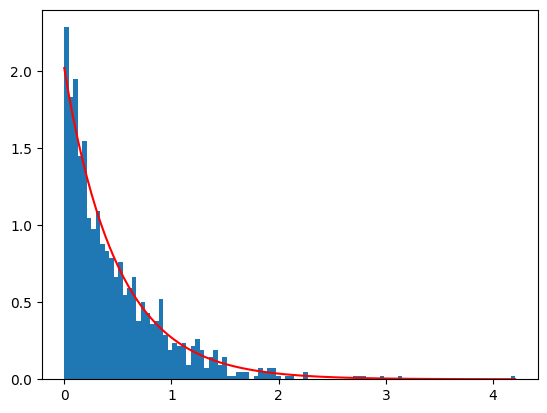

In [3]:
ce = combination_exponential(0.999, 2, 20)
X = ce.rvs(1000)

plt.hist(X, bins=100, density=True)
plt.plot(np.linspace(0, np.max(X), 100), [ce.pdf(x) for x in np.linspace(0, np.max(X), 100)], 'r')
plt.show()

In [3]:
from typing import List
class Rainfall():
    """
        Rainfall model
    """
    def __init__(self, lam, b, delta_1, delta_2, r, t=None, U_t=None):
        self.lam = lam
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2
        self.r = r
        self.ce = combination_exponential(b, delta_1, delta_2)
        # list which represents the Possion process N_t
        if t is None:
            self.t : List = []
        else:
            self.t = t
        # list which represents the quantities of rainfalls at the times t_i
        if U_t is None:
            self.U_t : List = []
        else:
            self.U_t = U_t
    def simulate_for_fixed_T(self, T):
        """
            Simulate the rainfalls on [0, T]
        """
        N_t = sps.poisson.rvs(self.lam*T)
        # no zero at the first
        self.t = np.sort(np.random.uniform(0, T, N_t))
        self.U_t = self.ce.rvs(N_t)

    def reset(self):
        """
            Reset the model
        """
        self.t = []
        self.U_t = []

    def copy(self):
        R = Rainfall(self.lam, self.b, self.delta_1, self.delta_2, self.r, self.t, self.U_t)
        return R
    
    def merge(self, t, U_t):
        """
            Merge two different rainfalls
        """
        merged_t = np.concatenate((self.t, t))
        merged_U_t = np.concatenate((self.U_t, U_t))
        sorted_indices = sorted(range(len(merged_t)), key=lambda k: merged_t[k])
        sorted_t = np.array(sorted(merged_t))
        sorted_U_t = np.array([merged_U_t[i] for i in sorted_indices])
        return Rainfall(self.lam, self.b, self.delta_1, self.delta_2, self.r, sorted_t, sorted_U_t)
    
    def get_volume(self, x0):
        """
            Get the volume of the barrage on [0, T]
            '''math
                X_t = x0 + A_t - int_0^t r*X_s ds
            '''
        """
        X = [x0]
        for i in range(1, len(self.t)):
            X.append(np.exp(-self.r*(self.t[i]-self.t[i-1]))*X[-1]+self.U_t[i])
        return X
    
    def get_volume_at_t(self, X, t):
        """
            Get the volume of the barrage at time t
        """
        if len(self.t) == 0: # no rain
            return np.exp(-self.r*t)*X[0]    

        if t > self.t[-1]:
            return np.exp(-self.r*(t-self.t[-1]))*X[-1]
        if t < self.t[0]:
            return np.exp(-self.r*t)*X[0]

        # get i such that t_i <= t < t_{i+1}
        i = 1
        while self.t[i] <= t and i < len(self.t)-1:
            i += 1
        return np.exp(-self.r*(t-self.t[i-1]))*X[i-1]


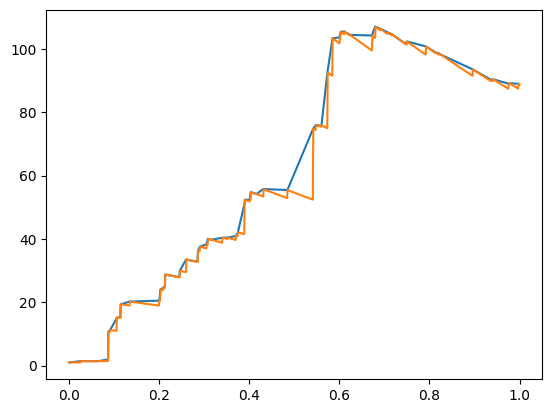

In [5]:
R = Rainfall(70, 0.9, 0.7, 0.07, 1)
R.simulate_for_fixed_T(1)
X = R.get_volume(1)
x = np.linspace(0, 1, 1000)
y = [R.get_volume_at_t(X, t) for t in x]
plt.plot(R.t, X)
plt.plot(x, y)
plt.show()

Here we determine the value of $x_0$.

In [5]:
R = Rainfall(70, 0.9, 0.7, 0.07, 1)
x_T_values = []
for _ in range(1000):
    R.reset()
    R.simulate_for_fixed_T(100)
    X = R.get_volume(5)
    x_T_values.append(R.get_volume_at_t(X, 100))
x_0 = np.mean(x_T_values)
print(x_0)


191.3250403649885


### Study of a single barrage

In [22]:
lambda_1 = 70
delta_1 = 0.07
delta_2 = 0.7
b = 0.9
alpha = 1e-6
T = 1
r_1 = 1

N = 1000
M = 20

class last_particle():
    """
        Last particle algorithm    
    """
    def __init__(self, N, M, x0, T, mode):
        """
            @param N: number of particles
            @param M: number of iterations: after M iterations, the new rainfall is considered independent from the original one
            @param x0: initial volume of the barrage
            @param T: time horizon
            @param mode: __T__ for Q1.(a) and __max__ for Q1.(b)
        """
        self.N = N
        self.M = M
        self.x0 = x0
        self.T = T
        self.mode = mode

    def get_new_rainfall(self, R, L, p=0.5, q=0.9):
        """
            Obtain a new rainfall > L almost independent from the original one
        """
        # idea c.f. TP 5
        R_start = R.copy()
        for _ in range(self.M):
            Unif = np.array(np.random.uniform(0, 1, len(R_start.t)))
            retained_indices = np.argwhere(Unif <= p)
            retained_indices = retained_indices.ravel()
            t_p = R_start.t[retained_indices]
            U_t_initial_p = R_start.U_t[retained_indices]
            R_other = Rainfall(R.lam*(1-p), R.b, R.delta_1, R.delta_2, R.r)
            R_other.simulate_for_fixed_T(self.T)
            
            # (×)Mention that for those U_t preserved, it is necessary to choose a new one with P(U_t, ·), where P is nu-revertible, c.f. silde 3 page 28 
            # (×)Use Metropolis-Hastings algorithm here, with q = standard gaussian, c.f. silde 2 page 22

            # For those U_t preserved, obtain a new one with original value in proportion q and new value given by nu in proportion (1-q), c.f. 26/04 visio online
            nu = combination_exponential(R.b, R.delta_1, R.delta_2)
            q_variation = nu.rvs(len(U_t_initial_p))
            U_t_p = q_variation*(1-q) + U_t_initial_p*q

            R_next = R_other.merge(t_p, U_t_p)
            R_next.lam = R.lam
            X_t_next = R_next.get_volume(self.x0)
            if self.mode == "__T__":
                if R_next.get_volume_at_t(X_t_next, T) > L:
                    R_start = R_next
            if self.mode == "__max__":
                if np.max(X_t_next) > L:
                    R_start = R_next
        return R_start
    # 输出accept的率试一试

    def get_critical_level_and_distribution(self, lam, b, delta_1, delta_2, r, alpha, switch=True, q=0.9, p=0.5):
        """
            Obtain the critical level of (1 - alpha) and overtaking distribution of this level;
            True to print the histo, False no
        """
        A_t = []
        critical_X_t = []
        for _ in range(self.N):
            R_initial = Rainfall(lam, b, delta_1, delta_2, r)
            R_initial.simulate_for_fixed_T(self.T)
            A_t.append(R_initial)
            X_t_initial = R_initial.get_volume(self.x0)
            if self.mode == "__T__":
                critical_X_t.append(R_initial.get_volume_at_t(X_t_initial, T))
            if self.mode == "__max__":
                critical_X_t.append(np.max(X_t_initial))
        L = np.min(critical_X_t)

        # c.f. silde 4 part 1 page 13
        stop_index = int(np.ceil(np.log(alpha) / np.log(1-1/self.N)))
        for k in range(stop_index):
            reached_indices = np.argwhere(critical_X_t == L)
            reached_indices = reached_indices.ravel()
            outer_indices = np.setdiff1d(np.arange(self.N), reached_indices)
            for i in reached_indices:
                j = np.random.choice(outer_indices)
                R_new = self.get_new_rainfall(A_t[j], L, q=q, p=p)
                A_t[i] = R_new
                X_t_new = R_new.get_volume(self.x0)
                if self.mode == "__T__":
                    critical_X_t[i] = R_new.get_volume_at_t(X_t_new, T)
                if self.mode == "__max__":
                    critical_X_t[i] = np.max(X_t_new)
            L = np.min(critical_X_t)
        if switch:
            plt.hist(critical_X_t , bins="auto", density=True, histtype="step", label="Histogramme n=%1.0f tirages" %self.N)
            plt.legend(fontsize=12, loc=9, bbox_to_anchor=(1.6, 1.0), ncol=1)
            plt.show()
        return L, critical_X_t
    
class naive_MonteCarlo():
    """
        Naive Monte-Carlo algorithm
    """
    def __init__(self, N, x0, T, mode):
        """
            __T__ for Q1.(a) and __max__ for Q1.(b)
        """
        self.N = N
        self.x0 = x0
        self.T = T
        self.mode = mode

    def get_critical_level(self, lam, b, delta_1, delta_2, r, alpha):
        """
            Obtain the critical level of (1 - alpha) where alpha should not be extremely small
        """
        considered_values = []
        for _ in range(self.N):
            R = Rainfall(lam, b, delta_1, delta_2, r)
            R.simulate_for_fixed_T(self.T)
            X_t = R.get_volume(self.x0)
            if self.mode == "__T__":
                considered_values.append(R.get_volume_at_t(X_t, self.T))
            if self.mode == "__max__":
                considered_values.append(np.max(X_t))

        # c.f. silde 2 page 5
        considered_values = sorted(np.array(considered_values))
        index = int(np.ceil((1-alpha)*self.N))
        L = considered_values[index-1]
        return L
    

In [7]:
class importance_sampling():
    """ 
        Importance sampling algorithm for the compound poisson process of parameters (lam, mu)
    """
    def __init__(self, M, x0, T, mode, sigma, beta):
        """
            importance sampling algorithm, here we use f(x) = sigma*x + beta

            @param mode: __T__ for Q1.(a) and __max__ for Q1.(b)
            @param sigma: parameter of the function f
            @param beta: parameter of the function f
        """
        self.M = M
        self.x0 = x0
        self.T = T
        self.mode = mode
        self.sigma = sigma
        self.beta = beta

    def get_lambda_f_nu_f(self, lam, b, delta_1, delta_2):
        """
            Get the parameters after the change of measure
        """
        lambda_f = lam*np.exp(self.beta)*(b*delta_1/(delta_1-self.sigma)+(1-b)*delta_2/(delta_2-self.sigma))
        b_f = b*delta_1/(delta_1-self.sigma)/(b*delta_1/(delta_1-self.sigma)+(1-b)*delta_2/(delta_2-self.sigma))
        delta_1_f = delta_1-self.sigma
        delta_2_f = delta_2-self.sigma
        return lambda_f, b_f, delta_1_f, delta_2_f


    def get_critical_level(self, lam, b, delta_1, delta_2, r, alpha):
        """
            Run the importance sampling algorithm to estimate E[g(gamma(A_t))], where gamma is a function applied to the trajectory of the compound Poisson process
            here A_t represents the rainfalls at time t
            if mode == __T__, gamma returns the volume at time T, i.e. gamma(A_t) = X_T where X_t is the volume of the barrage
            if mode == __max__, gamma returns the maximum volume on [0, T] i.e. gamma(A_t) = max(X_t)

            '''math
                E[g(gamma(A_t))] = exp((lam_f-lam)*T)1/M*\sum_{m=1}^M g(gamma(A_t^{(m)}))exp(-\sum_{i=1}^{N_T^{(m)}f(U_i^{(m)}))
            '''
            where A_t^{(m)} are M compound Poisson processes with parameters (lam_f, mu_f)

            If we want to estimate the (1-alpha) quantile of the distribution of gamma(A_t), we can use g = 1_{gamma(A_t) > L}
            i.e. we want to find L such that E[1_{gamma(A_t) > L}] = alpha

            An estimator of L can be obtained by sorting the values of gamma(A_t^{(m)})exp(-\sum_{i=1}^{N_T^{(m)}f(U_i^{(m)})) and taking the alpha*exp(-(lam_f-lam)*T)th value.

        """
        lambda_f, b_f, delta_1_f, delta_2_f = self.get_lambda_f_nu_f(lam, b, delta_1, delta_2)
        values_Xt = []
        values = []
        for _ in range(self.M):
            R = Rainfall(lambda_f, b_f, delta_1_f, delta_2_f, r)
            R.simulate_for_fixed_T(self.T)
            X_t = R.get_volume(self.x0)

            # apply the fuction gamma
            if self.mode == "__T__":
                values_Xt.append(np.exp(-self.sigma*np.sum(R.U_t)-self.beta*len(R.U_t)))
                values.append(R.get_volume_at_t(X_t, self.T))
            if self.mode == "__max__":
                values_Xt.append(np.exp(-self.sigma*np.sum(R.U_t)-self.beta*len(R.U_t)))
                values.append(np.max(X_t))
            
        alpha_f = alpha*np.exp(-(lambda_f-lam)*self.T)
        indices = np.argsort(values)
        sorted_values_Xt = [values_Xt[i] for i in indices][::-1]
        idx = 0
        sum_values = 0
        while sum_values < alpha_f*self.M and idx < self.M:
            sum_values += sorted_values_Xt[idx]
            idx += 1
        L = values[indices[-idx]]
        return L
        

Here we show that these two algorithms are compatible when $\alpha$ is not extremely small.

In [135]:
alg_max_1 = last_particle(N*2, M*2, 100, 20, "__max__")
# alg_T_1 = last_particle(N, M, 100, 20, "__T__")
# # alg_max_2 = naive_MonteCarlo(N*10, 100, 20, "__max__")
# # alg_T_2 = naive_MonteCarlo(N*10, 100, 20, "__T__")
# alg_max_3 = importance_sampling(N*10, 100, 20, "__max__", 0.06, 0.2)
# # R = Rainfall(1, 0.9, 0.07, 0.7, 0.1)
# # R.simulate_for_fixed_T(100)
# print(alg_max_1.get_critical_level_and_distribution(1, 0.9, 0.07, 0.7, 0.1, 0.000001, False, q=1))
# # print(alg_max_2.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.1))
# # print(alg_T_1.get_critical_level_and_distribution(1, 0.9, 0.07, 0.7, 0.1, 0.001, False))
# # print(alg_T_2.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.1))
# # print(alg_max_3.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.001))

For that the algorithm works, one should let $M$ be bigger such that, during the Markov chain, the Poisson processus will not be rejected all the iteration.

In [8]:
alg_max_3 = importance_sampling(N*10, 100, 20, "__max__", 0, -0.2)
alg_max_2 = naive_MonteCarlo(N*10, 100, 20, "__max__")
# print(alg_max_2.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.000001))
# print(alg_max_3.get_critical_level(1, 0.9, 0.07, 0.7, 0.1, 0.000001))

Here we show that these two algorithms are compatible.

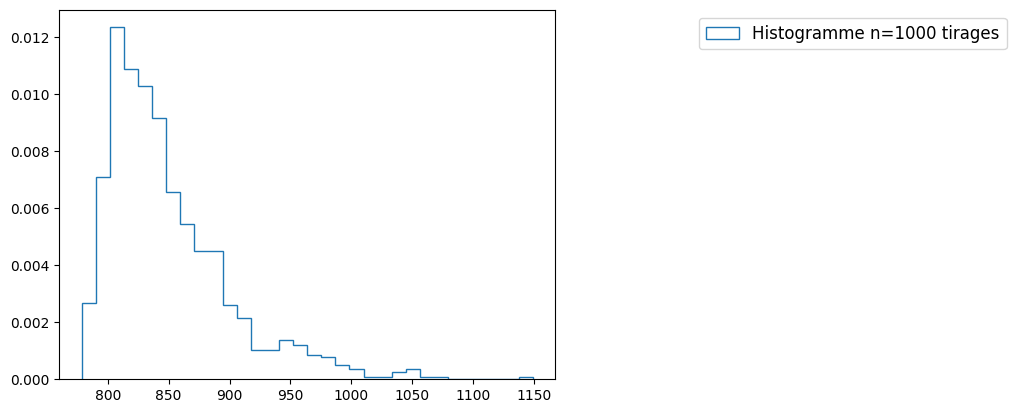

[778.6282904298903, 808.5721205525367]
[796.1202970959419, 817.0918158310174]


In [24]:
alg_max = last_particle(100, M, 190, 1, "__max__")
L_lp = []
values_lp = []
for _ in range(10):
    L, values = alg_max.get_critical_level_and_distribution(70, 0.9, 0.07, 0.7, 1, 0.1, False, p=0.6)
    L_lp.append(L)
    values_lp = values_lp + values
plt.hist(values_lp, bins="auto", density=True, histtype="step", label="Histogramme n=%1.0f tirages" %N)
plt.legend(fontsize=12, loc=9, bbox_to_anchor=(1.6, 1.0), ncol=1)
plt.show()
print([min(L_lp), max(L_lp)])
alg_max_2 = naive_MonteCarlo(N, 190, 1, "__max__")
L_nM = []
for _ in range(10):
    L = alg_max_2.get_critical_level(70, 0.9, 0.07, 0.7, 1, 0.1)
    L_nM.append(L)
print([min(L_nM), max(L_nM)])

We condsider now the parametre $p\in[0,1]$. The parametre $p$ indicates the proportion of jump points reserved.

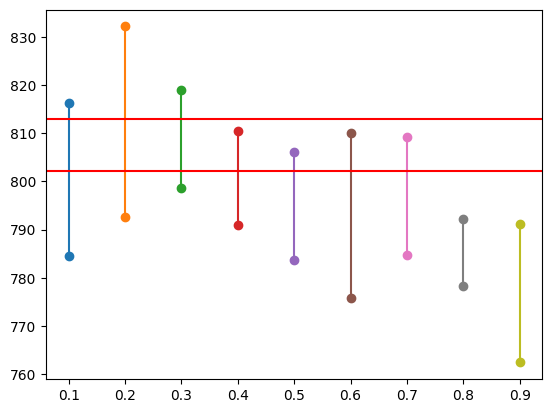

In [27]:
alg_max = last_particle(100, M, 190, 1, "__max__")
for p in range(1, 10):
    L_lp = []
    values_lp = []
    for _ in range(10):
        L, values = alg_max.get_critical_level_and_distribution(70, 0.9, 0.07, 0.7, 1, 0.1, False, p=p/10)
        L_lp.append(L)
        values_lp = values_lp + values
    plt.plot([p/10, p/10], [min(L_lp), max(L_lp)], marker='o')
alg_max_2 = naive_MonteCarlo(N, 190, 1, "__max__")
L_nM = []
for _ in range(10):
    L = alg_max_2.get_critical_level(70, 0.9, 0.07, 0.7, 1, 0.1)
    L_nM.append(L)
plt.axhline(y=min(L_nM), color='r', linestyle='-')
plt.axhline(y=max(L_nM), color='r', linestyle='-')
plt.show()

We consider now the parametre $q\in[0,1]$. The $q$ indicates the proportion of original value.

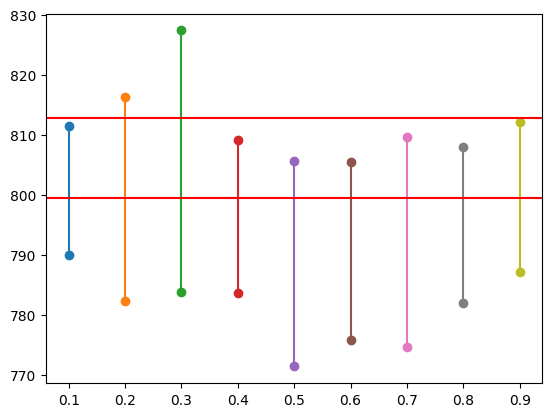

In [28]:
alg_max = last_particle(100, M, 190, 1, "__max__")
for q in range(1, 10):
    L_lp = []
    values_lp = []
    for _ in range(10):
        L, values = alg_max.get_critical_level_and_distribution(70, 0.9, 0.07, 0.7, 1, 0.1, False, q=q/10)
        L_lp.append(L)
        values_lp = values_lp + values
    plt.plot([q/10, q/10], [min(L_lp), max(L_lp)], marker='o')
alg_max_2 = naive_MonteCarlo(N, 190, 1, "__max__")
L_nM = []
for _ in range(10):
    L = alg_max_2.get_critical_level(70, 0.9, 0.07, 0.7, 1, 0.1)
    L_nM.append(L)
plt.axhline(y=min(L_nM), color='r', linestyle='-')
plt.axhline(y=max(L_nM), color='r', linestyle='-')
plt.show()